# Memory Capacity ADDNs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import populations
from BCM_experiment import params_start_evolution_adaptive
from utils import network_memory_capacity, genome_memory_capacity
from simulator import NetworkSimulator
from network import DistDelayNetwork
from reservoirpy import datasets

In [3]:
exp_path = "ADDN_further_experiments/Results N300 K5/2023-08-24_delay_True_bcm_True_growing_False.p"
exp_file = open(exp_path, 'rb')
exp_results_dict = pkl.load(exp_file)

ddn_path = "ADDN_further_experiments/Results N300 K5/2023-08-24_delay_True_bcm_False_growing_False.p"
ddn_file = open(ddn_path, 'rb')
ddn_results_dict = pkl.load(ddn_file)

bl_path = "ADDN_further_experiments/Results N300 K5/2023-08-24_delay_False_bcm_False_growing_False.p"
bl_file = open(bl_path, 'rb')
bl_results_dict = pkl.load(bl_file)

growddn_path = "ADDN_further_experiments/Results N300 K5/2023-08-24_delay_True_bcm_False_growing_True.p"
growddn_file = open(growddn_path, 'rb')
growddn_results_dict = pkl.load(growddn_file)

growaddn_path = "ADDN_further_experiments/Results N300 K5/2023-08-24_delay_True_bcm_True_growing_True.p"
growaddn_file = open(growaddn_path, 'rb')
growaddn_results_dict = pkl.load(growaddn_file)

alphas = [1e-8, 1e-6, 1e-4, 1e-2, 1]

In [4]:
print(exp_results_dict['tau range'])

[17, 17]


In [5]:
ex_net = exp_results_dict['example net']
best_parameters = exp_results_dict['evolutionary strategy'].best.x
all_parameters = exp_results_dict['parameters']
unevolved_net = ex_net.get_new_network_from_serialized(all_parameters[0, 0, :])
gen=190
i=15
evolved_net = ex_net.get_new_network_from_serialized(all_parameters[gen, i, :])
print("using parameters gen " + str(gen) + " individual " + str(i))
print("performance during evolution: " + str(exp_results_dict['validation performance'][gen, i]))
mg_seq = datasets.mackey_glass(10000)

ddn_net = ddn_results_dict['example net']
best_ddn_parameters = ddn_results_dict['evolutionary strategy'].best.x
evolved_ddn_net = ddn_net.get_new_network_from_serialized(best_ddn_parameters)


using parameters gen 190 individual 15
performance during evolution: [404.  396.6 460.  490.4 403.8]


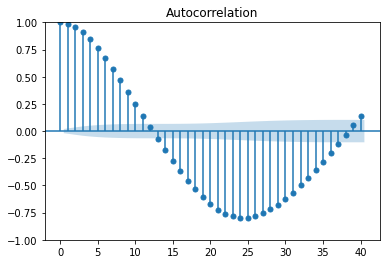

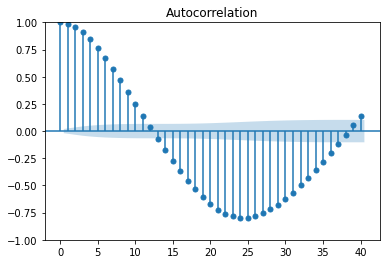

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
# plt.figure()
plot_acf(mg_seq)

## Memory Capacity no delay vs delay (unevolved)


In [7]:
bl_validation_scores = bl_results_dict['validation performance']
best_gen = np.argmax(np.mean(np.mean(bl_validation_scores, axis=-1), axis=-1))
best_i = np.argmax(np.mean(bl_validation_scores[best_gen, :, :], axis=-1))
print(best_gen, best_i)

188 17


In [8]:
from scipy.special import softmax

bl_net = bl_results_dict['example net']

bl_parameters = bl_results_dict['parameters']

gen=best_gen
i=best_i

evolved_bl_net = bl_net.get_new_network_from_serialized(bl_parameters[gen,i])
print("using parameters gen " + str(gen) + " individual " + str(i))
print("performance during evolution: " + str(bl_results_dict['validation performance'][gen, i, :]))
k = evolved_bl_net.k

mix = np.ones((k,))
mix = softmax(mix)

var = np.ones((k, 2)) * 0.1
corr = np.ones((k,)) * 0
mu = np.zeros((k, 2))
                                                                                    

# m_caps_evolved_bl = network_memory_capacity(evolved_bl_net, 150, 1000, None, 400, [100000], reps=10)
m_caps_delays_added = []    
added_delays_net = populations.GMMPopulation(evolved_bl_net.N, mix, mu, var, corr, evolved_bl_net.inhibitory, evolved_bl_net.connectivity, evolved_bl_net.cluster_connectivity, evolved_bl_net.weight_scaling, evolved_bl_net.weight_mean,
                                             evolved_bl_net.bias_scaling, evolved_bl_net.bias_mean, evolved_bl_net.decay, evolved_bl_net.size_in, evolved_bl_net.size_out, (0, 0), evolved_bl_net.activation_func, evolved_bl_net.autapse, 
                                             .0005, evolved_bl_net.x_lim, evolved_bl_net.y_lim, evolved_bl_net.fixed_delay)

for var in np.arange(0.001, 5.001, 1):
    increasing_delay_net = DistDelayNetwork(added_delays_net.W, added_delays_net.WBias, added_delays_net.n_type, added_delays_net.coordinates * var, added_delays_net.decay, 
                                            added_delays_net.neurons_in, added_delays_net.neurons_out, added_delays_net.activation_func, added_delays_net.dt)
    print(np.max(increasing_delay_net.D))
#     sim = NetworkSimulator(increasing_delay_net)
#     sim.visualize(np.random.uniform(size=100))

    delays_added_memory_capacity = network_memory_capacity(increasing_delay_net, 150, 1000, None, 400, alphas, reps=10)
    m_caps_delays_added.append(delays_added_memory_capacity)

using parameters gen 188 individual 17
performance during evolution: [228.  167.   81.  270.2 171. ]
1
45
90
135
180


Text(0, 0.5, 'Correlation between input and reproduced input')

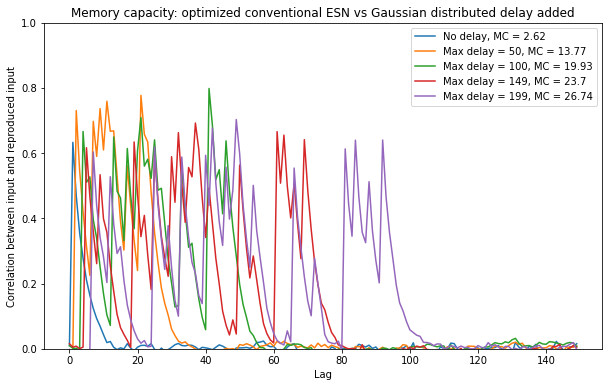

In [10]:
plt.figure(figsize = (10,6))
# plt.plot(m_caps_evolved_bl)
total_mc = []
for mc in m_caps_delays_added:
    plt.plot(mc)
    total_mc.append(round(np.sum(mc), 2))

plt.title("Memory capacity: optimized conventional ESN vs Gaussian distributed delay added")
plt.ylim(0, 1)
# plt.xlim(0, 80)
plt.legend([
    'No delay, MC = ' + str(total_mc[0]),
    'Max delay = 50, MC = ' + str(total_mc[1]),
    'Max delay = 100, MC = ' + str(total_mc[2]),
    'Max delay = 149, MC = ' + str(total_mc[3]),
    'Max delay = 199, MC = ' + str(total_mc[4]),
])
plt.xlabel("Lag")
plt.ylabel("Correlation between input and reproduced input")

# print(np.sum(m_caps_evolved_bl))
# print(np.max(added_delays_net.D))

In [46]:
plt.figure(figsize = (12,8))
plt.plot(m_caps_evolved_bl)
for mc in m_caps_delays_added:
    plt.plot(mc)
    print(np.sum(mc))
plt.ylim(0, 1)
plt.legend(['Evolved No Delay', 'Random Delays added to same network'])
print(np.sum(m_caps_evolved_bl))
print(np.max(added_delays_net.D))

NameError: name 'm_caps_evolved_bl' is not defined

<Figure size 864x576 with 0 Axes>

In [11]:
training_sequence = datasets.mackey_glass(900)
evolved_ddn_net.reset_network()
removed_delays = DistDelayNetwork(evolved_ddn_net.W, evolved_net.WBias, evolved_net.n_type, evolved_net.coordinates, evolved_net.decay, evolved_net.neurons_in, evolved_net.neurons_out, 
                                  evolved_net.activation_func, evolved_net.dt, evolved_net.theta_window, evolved_net.theta_y0, np.max(evolved_net.lr), var_delays=False)
# sim = NetworkSimulator(evolved_net, True)
# sim.warmup(training_sequence[:400])
# sim.unsupervised(training_sequence[400:])

# sim_no_delays = NetworkSimulator(evolved_net)
# sim_no_delays.warmup(training_sequence[:400])
# sim_no_delays.unsupervised(training_sequence[400:])

m_caps_evolved_net = network_memory_capacity(evolved_ddn_net, 150, 1000, None, 400, alphas, reps=20)
m_caps_removed_delays = network_memory_capacity(removed_delays, 150, 1000, None, 400, alphas, reps=20)

16.573668121058823
9.731751082554272


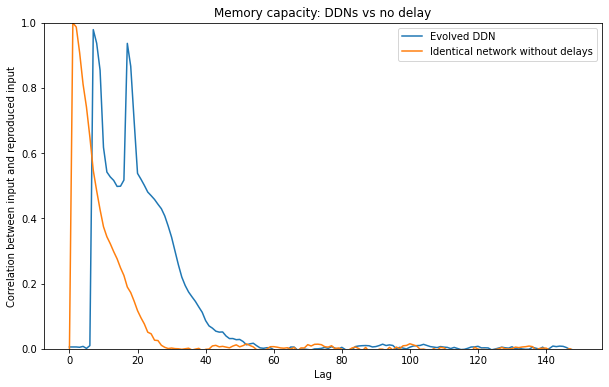

In [12]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title("Memory capacity: DDNs vs no delay")
plt.plot(m_caps_evolved_net)
plt.plot(m_caps_removed_delays)
plt.ylim(0, 1)
plt.xlabel("Lag")
plt.ylabel("Correlation between input and reproduced input")
plt.legend(['Evolved DDN', 'Identical network without delays'])
print(np.sum(m_caps_evolved_net))
print(np.sum(m_caps_removed_delays))
# print(np.max(added_delays_net.D))

## Memory Capacity throughout evolution

In [ ]:
m_cap_evo_bl = []
scores = np.mean(bl_results_dict['validation performance'], axis=-1)
ex_net = bl_results_dict['example net']

for gen in np.arange(0, 200, 10):
    pop = bl_results_dict['parameters'][gen, :, :]
    i = np.argmax(scores[gen])
    print(gen, i)
    m_cap = genome_memory_capacity(pop[i, :], ex_net, 100, 1000, None, 400, alphas, eval_reps=5, genome_reps=5)
    m_cap_evo_bl.append(m_cap)

In [ ]:
m_cap_evo_ddn = []
scores = np.mean(ddn_results_dict['validation performance'], axis=-1)
ex_net = ddn_results_dict['example net']

for gen in np.arange(0, 200, 10):
    pop = ddn_results_dict['parameters'][gen, :, :]
    i = np.argmax(scores[gen])
    print(gen, i)
    m_cap = genome_memory_capacity(pop[i, :], ex_net, 100, 1000, None, 400, alphas, eval_reps=5, genome_reps=5)
    m_cap_evo_ddn.append(m_cap)

0 15
10 13
20 18


In [6]:
m_cap_evo_addn = []
scores = np.mean(exp_results_dict['validation performance'], axis=-1)
ex_net = exp_results_dict['example net']

for gen in np.arange(0, 200, 10):
    pop = exp_results_dict['parameters'][gen, :, :]
    i = np.argmax(scores[gen])
    print(gen, i)
    m_cap = genome_memory_capacity(pop[i, :], ex_net, 100, 1000, None, 400, [100000], eval_reps=5, genome_reps=5)
    m_cap_evo_addn.append(m_cap)

0 6


C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encoun

10 17
20 7


C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encoun

30 18


C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encoun

40 5
50 10
60 11
70 15
80 8
90 7
100 18
110 4
120 0
130 13


C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encoun

140 18


C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encoun

150 16
160 7
170 18
180 14
190 13


In [86]:
m_cap_evo_addn_10 = []
scores = np.mean(exp_results_dict['validation performance'], axis=-1)
ex_net = exp_results_dict['example net']

def z_func(x):
    return x**10

for gen in np.arange(0, 200, 10):
    pop = exp_results_dict['parameters'][gen, :, :]
    i = np.argmax(scores[gen])
    print(gen, i)
    m_cap = genome_memory_capacity(pop[i, :], ex_net, 100, 1000, z_func, 400, [100000], eval_reps=5, genome_reps=5)
    m_cap_evo_addn_10.append(m_cap)
    

0 6
10 17
20 7
30 18
40 5
50 10
60 11
70 15
80 8
90 7
100 18
110 4
120 0
130 13
140 18
150 16
160 7
170 18
180 14
190 13


In [93]:
m_cap_evo_gddn = []
scores = np.mean(growddn_results_dict['validation performance'], axis=-1)
ex_net = growddn_results_dict['example net']

for gen in np.arange(0, 200, 10):
    pop = growddn_results_dict['parameters'][gen, :, :]
    i = np.argmax(scores[gen])
    print(gen, i)
    m_cap = genome_memory_capacity(pop[i, :], ex_net, 100, 1000, None, 400, [100000], eval_reps=5, genome_reps=5, n_sequences_unsupervised=0)
    m_cap_evo_gddn.append(m_cap)

0 7
10 3
20 0
30 10
40 9
50 15
60 17
70 10
80 4
90 14
100 3
110 12
120 17
130 5
140 15
150 14
160 1
170 11
180 7
190 14


In [101]:
m_cap_evo_gaddn = []
scores = np.mean(growaddn_results_dict['validation performance'], axis=-1)
ex_net = growaddn_results_dict['example net']

for gen in np.arange(0, 175, 10):
    pop = growaddn_results_dict['parameters'][gen, :, :]
    i = np.argmax(scores[gen])
    print(gen, i)
    m_cap = genome_memory_capacity(pop[i, :], ex_net, 100, 1000, None, 400, [100000], eval_reps=5, genome_reps=5, n_sequences_unsupervised=5)
    m_cap_evo_gaddn.append(m_cap)

0 5


C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encoun

10 9


C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))
C:\Users\Administrator\Documents\DistDelay\network.py:324: RuntimeWarning: overflow encoun

20 11
30 0
40 17
50 4
60 4
70 12
80 9
90 0
100 19
110 10
120 14
130 9
140 8
150 7
160 7
170 5


In [87]:
m_cap_evo_ddn_2 = np.array(m_cap_evo_ddn_2)

In [89]:
m_cap_evo_2_mean = np.mean(m_cap_evo_ddn_2, axis=1)

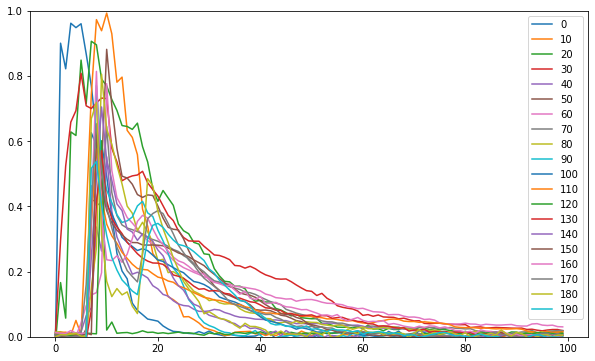

In [68]:
# autocorrs_tau = []
# for t in np.arange(12, 22, 4):
    mg = datasets.mackey_glass(1000, tau = t)
    lags = 100
    autocorrs = []
    for i in range(1, 1 + lags):
        autocorr = np.corrcoef(mg[i:].T, mg[:-i].T)[0, 1]
        autocorrs.append(autocorr)
    autocorrs_tau.append(autocorrs)

gens = np.arange(0, 199, 10)
plt.figure(figsize = (10,6))
for i in range(5):
    plt.figure()
    for j in range(4):
for i, m_cap in enumerate(np.mean(m_cap_evo_ddn, axis=1)):
    plt.plot(m_cap)
#     plt.plot(m_cap_evo_2_mean[i])
#     leg = ['Linear Memory capacity', 'Quadratic Memory capacity']
#     taus = np.arange(12, 22, 4)
#     for j, a in enumerate(autocorrs_tau):
#         plt.plot(np.abs(a), '--')
#         leg.append('Autocorrelation MG tau = ' + str(taus[j]))
plt.ylim(0,1)
# plt.title('Generation ' + str(gens[i])) 
plt.legend(gens)

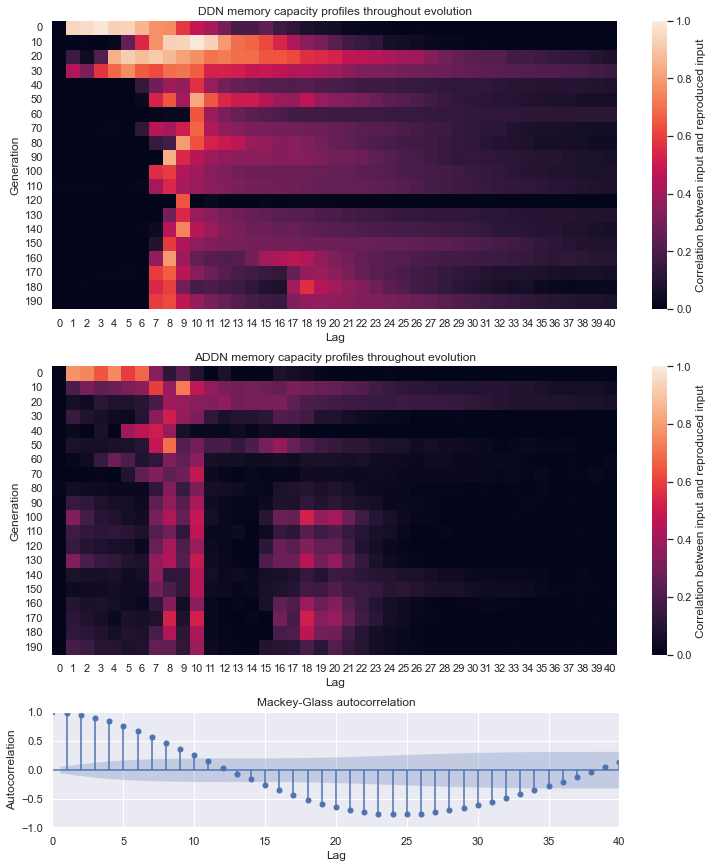

In [91]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
gens = np.arange(0, 199, 10)
sns.set_theme()
# fig, axs = plt.subplots(2, figsize =(12,12), gridspec_kw={'height_ratios': [2, 1]})
fig8 = plt.figure(figsize=(28, 14), constrained_layout=False)
gs1 = fig8.add_gridspec(nrows=5, ncols=6, left=0.05, right=0.4, wspace=10, hspace=0.5)
f8_ax1 = fig8.add_subplot(gs1[:2, :])
f8_ax2 = fig8.add_subplot(gs1[-1, :-1])
f8_ax3 = fig8.add_subplot(gs1[2:4, :])

# plt.figure(figsize=(10,6))
sns.heatmap(np.mean(m_cap_evo_ddn, axis=1)[:, :41], vmin=0, vmax=1, yticklabels=gens, cbar_kws={'label': 'Correlation between input and reproduced input'}, ax=f8_ax1)
sns.heatmap(np.mean(m_cap_evo_addn, axis=1)[:, :41], vmin=0, vmax=1, yticklabels=gens, cbar_kws={'label': 'Correlation between input and reproduced input'}, ax=f8_ax3)

f8_ax1.set_xlabel("Lag")
f8_ax1.set_ylabel("Generation")
f8_ax1.set_title("DDN memory capacity profiles throughout evolution")

f8_ax3.set_xlabel("Lag")
f8_ax3.set_ylabel("Generation")
f8_ax3.set_title("ADDN memory capacity profiles throughout evolution")

# plt.figure(figsize=(9.75,6) )
leg = []
# for t in np.arange(17, 18, 1):
#     mg = datasets.mackey_glass(1000, tau = t)
#     leg.append("Tau = " + str(t))
#     lags = 100
#     autocorrs = []
#     for i in range(1, 1 + lags):
#         autocorr = np.corrcoef(mg[i:].T, mg[:-i].T)[0, 1]
#         autocorrs.append(autocorr)
#     autocorrs_tau.append(autocorrs)
#     f8_ax2.plot(np.abs(autocorrs[:40]))
mg = datasets.mackey_glass(1000, tau =17)     
plot_acf(mg, f8_ax2, lags=40)
# plot_acf(mg**-9, f8_ax2, lags=40)

f8_ax2.set_xlim(0, 40)
f8_ax2.set_xlabel("Lag")
f8_ax2.set_ylabel("Autocorrelation")
f8_ax2.set_title("Mackey-Glass autocorrelation")

# f8_ax2.legend(leg, loc='upper right', bbox_to_anchor=(1.2, .85))
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

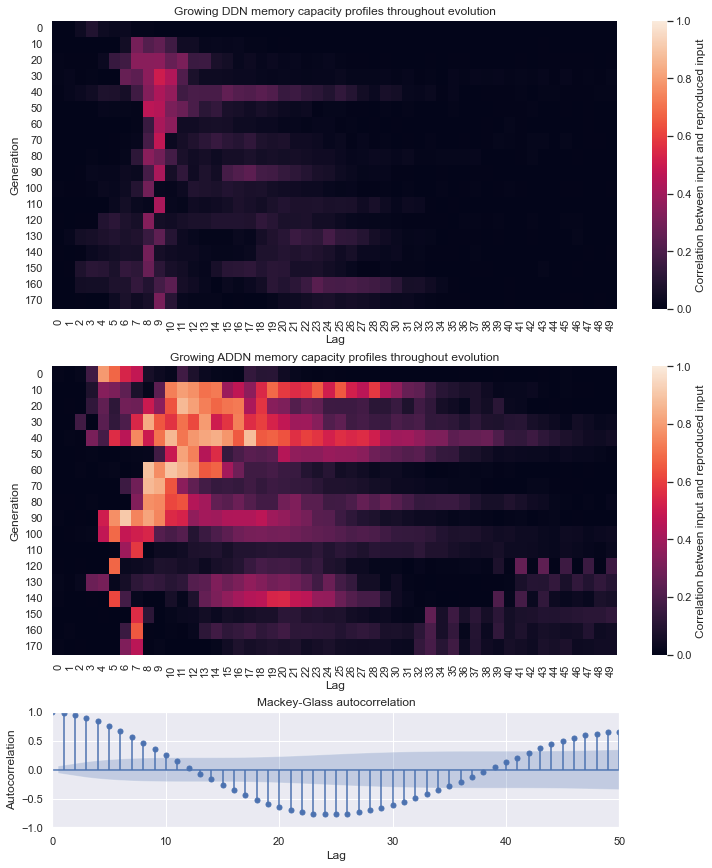

In [118]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
gens = np.arange(0, 199, 10)
sns.set_theme()
# fig, axs = plt.subplots(2, figsize =(12,12), gridspec_kw={'height_ratios': [2, 1]})
fig8 = plt.figure(figsize=(28, 14), constrained_layout=False)
gs1 = fig8.add_gridspec(nrows=5, ncols=6, left=0.05, right=0.4, wspace=10, hspace=0.5)
f8_ax1 = fig8.add_subplot(gs1[:2, :])
f8_ax2 = fig8.add_subplot(gs1[-1, :-1])
f8_ax3 = fig8.add_subplot(gs1[2:4, :])

# plt.figure(figsize=(10,6))
sns.heatmap(np.mean(m_cap_evo_gddn, axis=1)[:18, :50], vmin=0, vmax=1, yticklabels=gens[:18], cbar_kws={'label': 'Correlation between input and reproduced input'}, ax=f8_ax1)
sns.heatmap(np.mean(m_cap_evo_gaddn, axis=1)[:18, :50], vmin=0, vmax=1, yticklabels=gens[:18], cbar_kws={'label': 'Correlation between input and reproduced input'}, ax=f8_ax3)

f8_ax1.set_xlabel("Lag")
f8_ax1.set_ylabel("Generation")
f8_ax1.set_title("Growing DDN memory capacity profiles throughout evolution")

f8_ax3.set_xlabel("Lag")
f8_ax3.set_ylabel("Generation")
f8_ax3.set_title("Growing ADDN memory capacity profiles throughout evolution")

# plt.figure(figsize=(9.75,6) )
leg = []
# for t in np.arange(17, 18, 1):
#     mg = datasets.mackey_glass(1000, tau = t)
#     leg.append("Tau = " + str(t))
#     lags = 100
#     autocorrs = []
#     for i in range(1, 1 + lags):
#         autocorr = np.corrcoef(mg[i:].T, mg[:-i].T)[0, 1]
#         autocorrs.append(autocorr)
#     autocorrs_tau.append(autocorrs)
#     f8_ax2.plot(np.abs(autocorrs[:40]))
mg = datasets.mackey_glass(1000, tau =17)     
plot_acf(mg, f8_ax2, lags=101)
# plot_acf(mg**-9, f8_ax2, lags=40)

f8_ax2.set_xlim(0, 50)
f8_ax2.set_xlabel("Lag")
f8_ax2.set_ylabel("Autocorrelation")
f8_ax2.set_title("Mackey-Glass autocorrelation")

# f8_ax2.legend(leg, loc='upper right', bbox_to_anchor=(1.2, .85))
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

(0.0, 20.0)

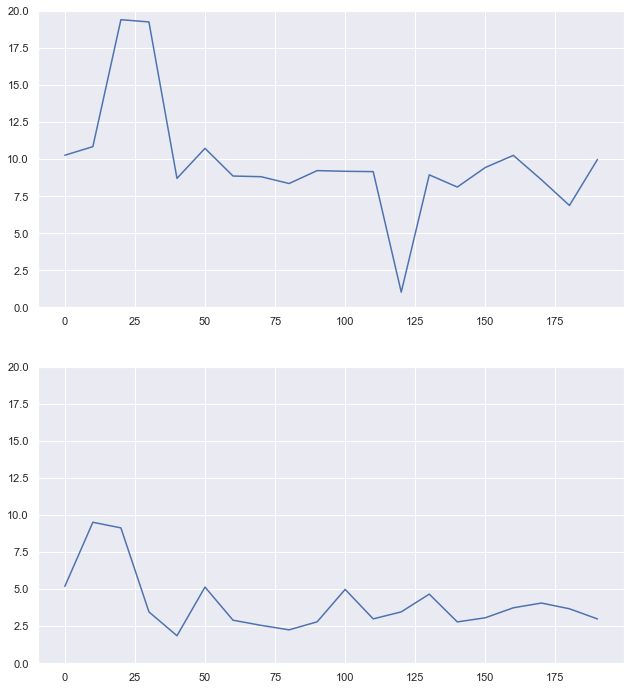

In [81]:
fig, axs = plt.subplots(2, figsize =(10.5,12))
axs[0].plot(gens, np.sum(np.mean(m_cap_evo_ddn, axis=1)[:, :100], axis=1))
axs[1].plot(gens, np.sum(np.mean(m_cap_evo_addn, axis=1)[:, :100], axis=1))
axs[0].set_ylim(0, 20)
axs[1].set_ylim(0, 20)

## Memory Capacity vs Autocorrelation of task signal

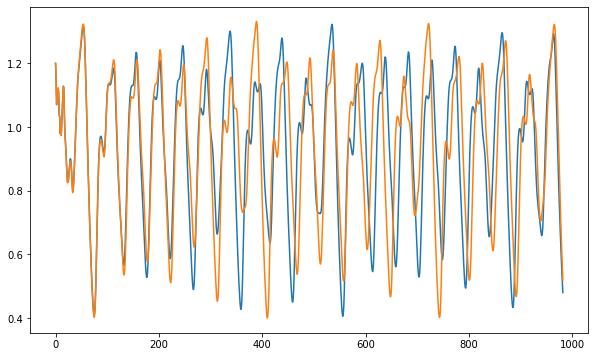

In [42]:
def recurrent_mg_compounding_noise(x_previous, tau=17, n=10, a=0.2, b=0.1, target_len=1000, noise_per_step=0):
    assert len(x_previous) > tau
    if len(x_previous) < target_len:
        noise = np.random.normal(0, 1) * noise_per_step
        x_new = noise + x_previous[-1] + (a * x_previous[-tau]) / (1 + x_previous[-tau]**n) - b*x_previous[-1]
        x_previous.append(x_new)
        return recurrent_mg_compounding_noise(x_previous, tau=tau, n=n, a=a, b=b, target_len=target_len, noise_per_step=noise_per_step)
    else:
        return x_previous[tau:]

x_start = list(np.random.uniform(.5, 1.2, size=18))
x_start[-1] = 1.2
plt.figure(figsize=(10,6))
plt.plot(recurrent_mg_compounding_noise(list(np.copy(x_start))))
plt.plot(recurrent_mg_compounding_noise(list(np.copy(x_start)), noise_per_step=.001))

# def compounding_noise(signal, noise_per_step):
    

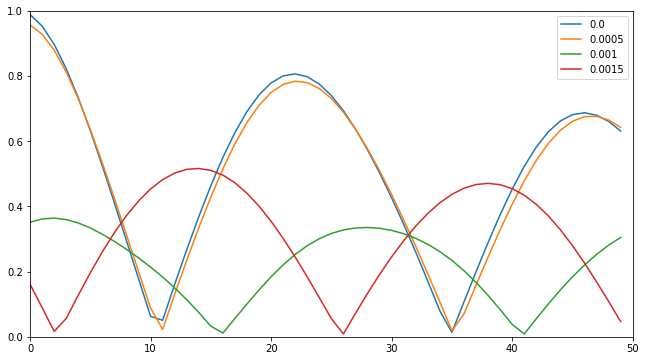

In [45]:
sig_len = 1000
base_noise = .0005
max_lag = 50
plt.figure(figsize=(10.8,6))
noise_mags = np.arange(0, 4, 1)
for noise_mag in noise_mags:
    #     mg = datasets.mackey_glass(sig_len)
    mg = np.array(recurrent_mg_compounding_noise(list(np.copy(x_start))))
    noisy_mg = np.array(recurrent_mg_compounding_noise(list(np.copy(x_start)), noise_per_step=base_noise * noise_mag))
#     plt.figure()
#     plt.plot(mg)
#     plt.plot(noisy_mg)
    autocorrs = []
    autocorrs10 = []
    for i in range(1, 1 + max_lag):
        autocorr = np.corrcoef(mg[i:].T, noisy_mg[:-i].T)[0, 1]
#         autocorr10 = np.corrcoef(mg[i:].T, noisy_mg[:-i].T)[0, 1]
        autocorrs.append(autocorr)
#         autocorrs10.append(autocorr10)

    plt.plot(np.abs(autocorrs))
#     plt.plot(np.abs(autocorrs10))
    plt.ylim(0,1)
    plt.xlim(0, max_lag)
plt.legend(noise_mags * base_noise)

In [128]:
scores = np.mean(growddn_results_dict['validation performance'], axis=-1)
ex_net = growddn_results_dict['example net']

gen = np.argmax(np.mean(scores, -1))
pop = growddn_results_dict['parameters'][gen, :, :]
i = np.argmax(scores[gen])
params = pop[i]
DDN = ex_net.get_new_network_from_serialized(params)

train_data = []
groups = []
labels = []
warmup = 400
for i in range(5):
    mg_train = datasets.mackey_glass(1900)
    mg_in = mg_train[warmup:-1]
    mg_labels = mg_train[warmup + 1:]
    labels.append(mg_labels)
    ddn_sim.reset()
    ddn_sim.warmup(mg_train[:warmup])
    ddn_sim = NetworkSimulator(DDN)
    net_act = ddn_sim.get_network_data(mg_in)
    train_data.append(net_act)
    groups.append(np.ones_like(mg_labels) * i)
    
train_data = np.concatenate(train_data, axis=1)
labels = np.concatenate(labels)
groups = np.concatenate(groups)

In [130]:
print(gen,i)

158 4


In [131]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import KFold
from utils import create_folds

folds = create_folds(train_data.T, labels, 10, groups)
alphas = [1e-8, 1e-6, 1e-4, 1e-2, 1]
model = RidgeCV(alphas=alphas, cv=folds)
print(train_data.shape)
model.fit(train_data.T, labels)


(299, 7495)


RidgeCV(alphas=[1e-08, 1e-06, 0.0001, 0.01, 1],
        cv=[(array([ 750,  751,  752, ..., 7492, 7493, 7494]),
             array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  8...
       7417, 7418, 7419, 7420, 7421, 7422, 7423, 7424, 7425, 7426, 7427,
       7428, 7429, 7430, 7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438,
       7439, 7440, 7441, 7442, 7443, 7444, 7445, 7446, 7447, 7448, 7449,
       7450, 7451, 7452, 7453, 7454, 7455, 7456, 7457, 7458, 7459, 7460,
       7461, 7462, 7463, 7464, 7465, 7466, 7467, 7468, 7469, 7470, 7471,
       7472, 7473, 7474, 7475, 7476, 7477, 7478, 7479, 7480, 7481, 7482,
       7483, 7484, 7485, 7486, 7487, 7488, 7489, 7490, 7491, 7492, 7493,
       7494]))])

In [177]:
ddn_sim.reset()
mg_test = datasets.mackey_glass(2000)
ddn_sim.warmup(mg_test[:400])
test_act = ddn_sim.get_network_data(mg_test[400:])
noise = np.random.uniform(size=test_act.T.shape)

predictions = model.predict(test_act.T)

0.01


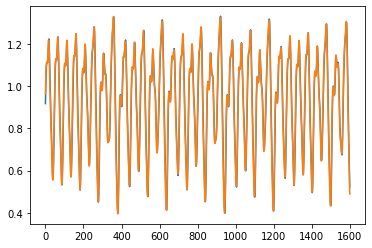

In [178]:
plt.plot(mg_test[400:])
plt.plot(predictions)
print(model.alpha_)

In [139]:
DDN.reset_activity()
m_cap = network_memory_capacity(DDN, 150, 5000, None, 400, [model.alpha_], reps=10)

KeyboardInterrupt: 

(0.0, 100.0)

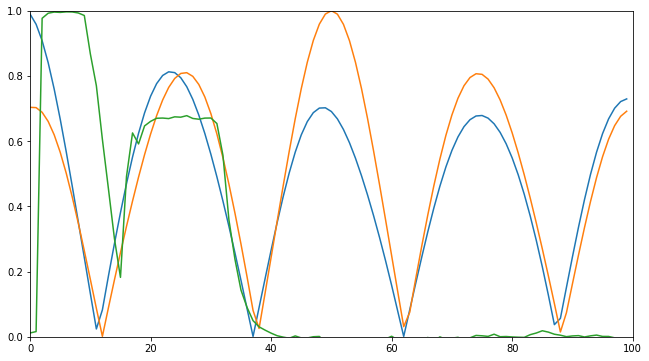

In [186]:
max_lag = 100
plt.figure(figsize=(10.8,6))
pred_corrs = []
autocorrs = []
extra = 50
for i in range(1, 1 + max_lag):
    pred_corr = np.corrcoef(mg_test[400+i:-extra].T, predictions[extra:-i].T)[0, 1]
    pred_corrs.append(pred_corr)
    
    autocorr = np.corrcoef(mg_test[400+i:].T, mg_test[400:-i].T)[0, 1]
    autocorrs.append(autocorr)

plt.plot(np.abs(autocorrs))
plt.plot(np.abs(pred_corrs))
plt.plot(m_cap[:100])
plt.ylim(0,1)
plt.xlim(0, max_lag)


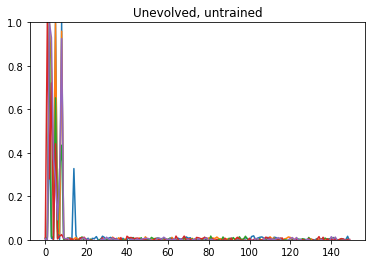

In [19]:
plt.figure()
plt.title('Unevolved, untrained')
plt.plot(np.array(m_caps_unevolved).T)
plt.ylim(0, 1)
plt.show()

In [60]:
m_cap_evo = []
scores = np.mean(bl_results_dict['validation performance'], axis=-1)
ex_net = bl_results_dict['example net']
for gen in np.arange(0, 200, 10):
    pop = bl_results_dict['parameters'][gen, :, :]
    i = np.argmax(scores[gen])
    print(gen, i)
    m_cap = genome_memory_capacity(pop[i, :], ex_net, 100, 1000, None, 400, [100000], eval_reps=5, genome_reps=5)
    m_cap_evo.append(m_cap)

0 6
10 12
20 12
30 5
40 0
50 18
60 17
70 2
80 19
90 6
100 16
110 17
120 3
130 14
140 8
150 3
160 0
170 3
180 9
190 2


In [61]:
m_cap_evo = np.array(m_cap_evo)

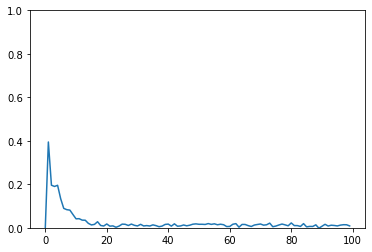

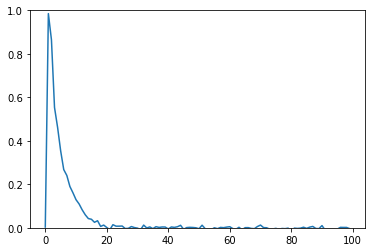

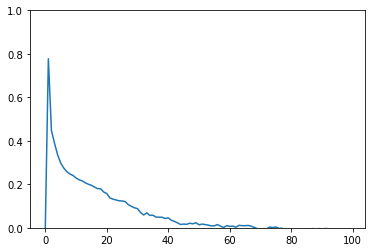

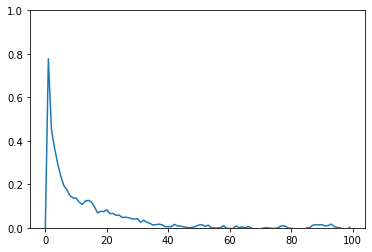

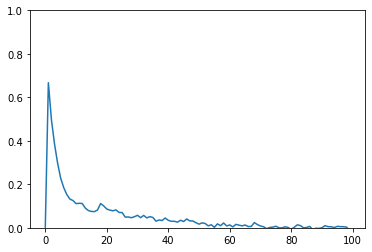

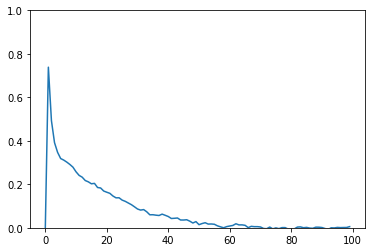

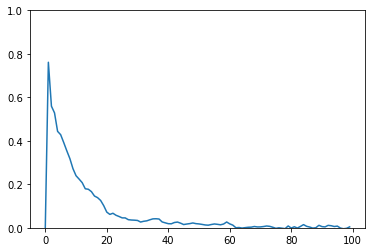

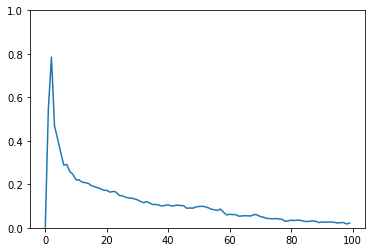

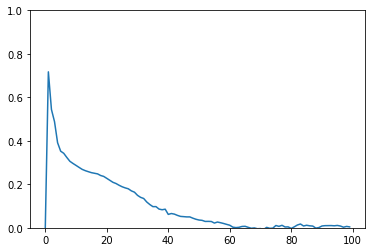

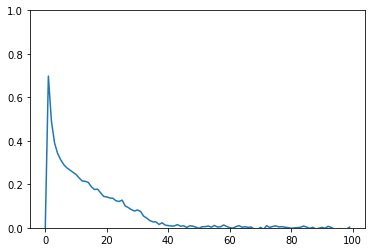

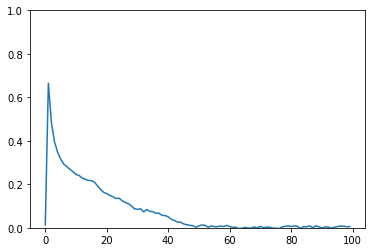

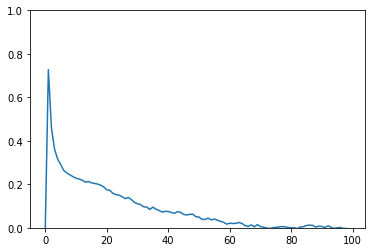

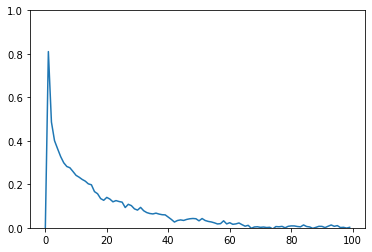

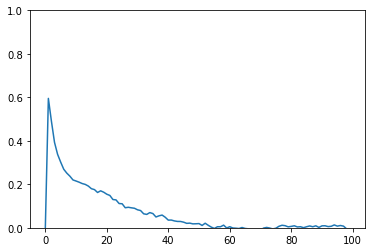

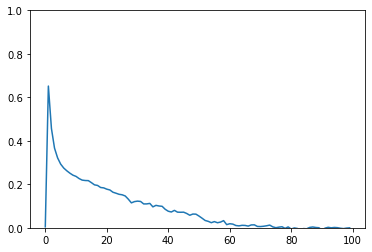

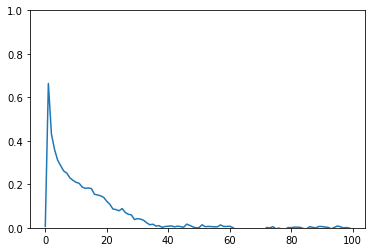

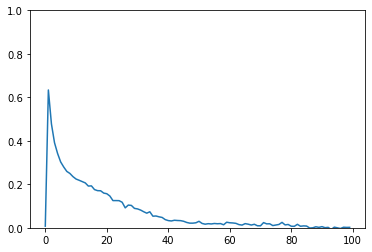

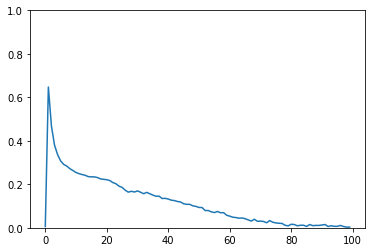

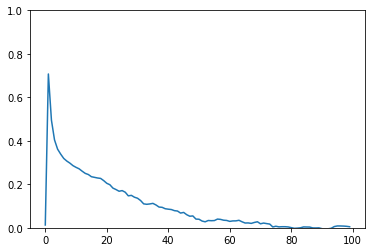

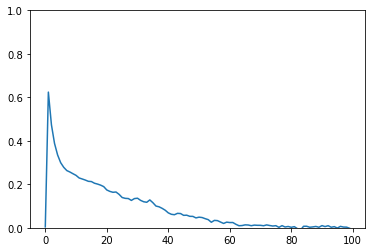

In [62]:
for m_cap in np.mean(m_cap_evo, axis=1):
    plt.figure()
    plt.plot(m_cap)
    plt.ylim(0,1)
# plt.legend(np.arange(m_cap_evo.shape[0]))

## Effect of BCM on memory capacity

In [52]:
evolved_net.reset_network()
sim = NetworkSimulator(evolved_net)
mg = datasets.mackey_glass(5400)

m_caps_bcm = {}
for i in range(10):
    sim.full_reset()
    sim.warmup(mg[:400])
    training_sequence = mg[400 : 400 + (i+1)*500]
    print(len(training_sequence))
    sim.unsupervised(training_sequence)
    m_cap_i = network_memory_capacity(evolved_net, 100, 1000, None, 400, [100000], reps=10)
    m_caps_bcm[len(training_sequence)] = m_cap_i

500
1000
1500
2000
2500
3000
3500
4000
4500
5000


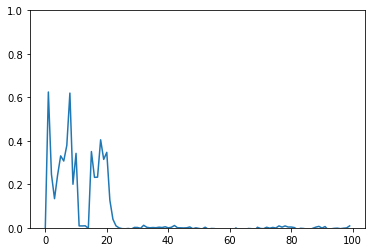

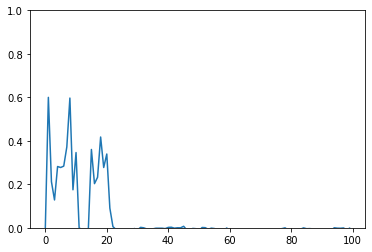

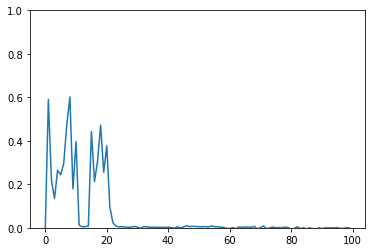

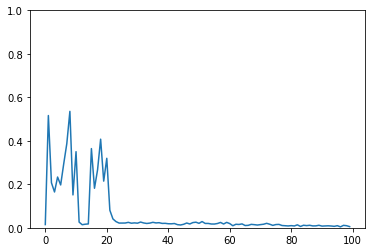

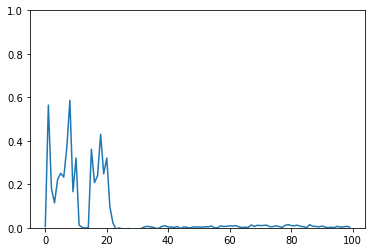

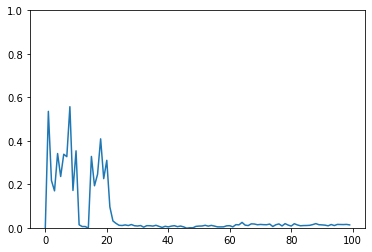

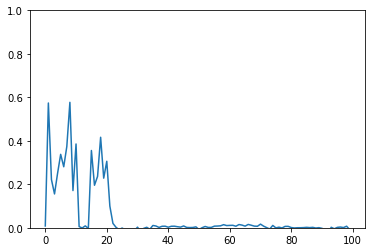

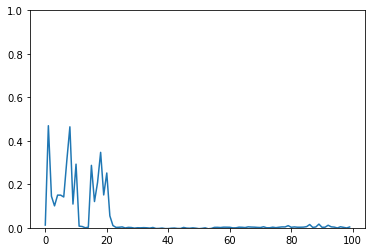

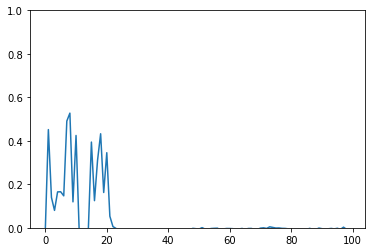

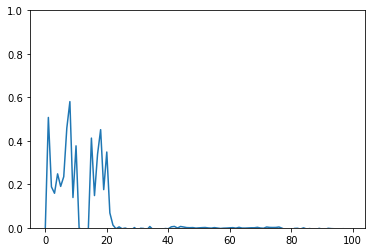

In [56]:
for key in m_caps_bcm:
    plt.figure()
    plt.plot(m_caps_bcm[key])
    plt.ylim(0,1)

In [59]:
evolved_net.reset_network()
sim = NetworkSimulator(evolved_net)

m_caps_tau = {}
for tau in range(12,22):
    print(tau)
    mg = datasets.mackey_glass(900, tau=tau)
    sim.full_reset()
    sim.warmup(mg[:400])
    training_sequence = mg[400:]
    sim.unsupervised(training_sequence)
    m_cap_i = network_memory_capacity(evolved_net, 100, 1000, None, 400, [100000], reps=10)
    m_caps_tau[tau] = m_cap_i

12
13
14
15
16
17
18
19
20
21


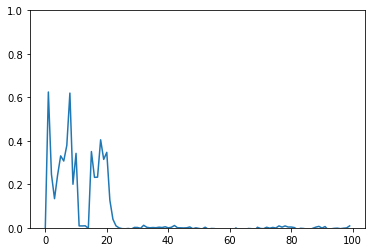

In [58]:
for key in m_caps_tau:
    plt.figure()
    plt.plot(m_caps_bcm[key])
    plt.ylim(0,1)